In [1]:
import numpy as np
from master_lib.utils import files_and_directories
import pandas as pd
from master_lib.model.generator import DataGenerator
from typing import List

C:\ProgramData\Anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
def dataset_partition(train_images_path_list: List, coef: float = 0.3):
    up = int(np.ceil(len(train_images_path_list)*(1 - coef)))
    return train_images_path_list[:up], train_images_path_list[up:]

In [3]:
dataset_path = r'C:\Users\MikołajStryja\Documents\Studia\master\dataset.json'
dataset = files_and_directories.load_json(dataset_path)
dataset_images = r'C:\Users\MikołajStryja\Documents\Studia\siim-covid19-detection'
# Dataset = evaluate_dataset_to_prediction(dataset_path, dataset_images)

In [4]:
# len(Dataset)
dataset = files_and_directories.load_json(dataset_path)
train_imgs = files_and_directories.list_train_images(dataset_images)

In [5]:
# model definition
import PIL
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = 4

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

model_archive = r'C:\Users\MikołajStryja\Documents\Studia\master\trained_models'

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7262625657399789947
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12620977648761081052
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [21]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7, verbose=1)

filepath = r'C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(filepath, 'model4_checkpoints'), monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learning_rate = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=1
)

In [7]:
Xtrain, Xval = dataset_partition(train_imgs)
training_generator = DataGenerator(Xtrain, batch_size=16)
validation_generator = DataGenerator(Xval, batch_size=16)

In [20]:
# Model definiton

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(512, 512, 1)),
    layers.Conv2D(1, (3, 3), padding='same', activation='relu', name="first_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(1, (5, 5), padding='same', activation='relu', name="second_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(1, (5, 5), padding='same', activation='relu', name="third_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(1, (7, 7), padding='same', activation='relu', name="fourth_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [46]:

model_name = 'Sequential_1'
model.save(os.path.join(model_archive, model_name))

INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\trained_models\Sequential_1\assets


In [47]:
model_img_name = 'model_architecture.png'

In [18]:
model.history.params

{'verbose': 2, 'epochs': 1, 'steps': 132}

In [50]:
tf.keras.utils.plot_model(model, to_file=os.path.join(model_archive, model_name, model_img_name), show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [16]:
model2 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(512, 512, 1)),
    layers.Conv2D(1, (5, 5), padding='same', activation='relu', name="first_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(1, (3, 3), padding='same', activation='relu', name="second_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model2_name = 'Sequential_2'

In [59]:
model2.fit(training_generator,
        epochs=20,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[early_stop])

model2.save(os.path.join(model_archive, model2_name))

Epoch 1/20
 90/132 [===================>..........] - ETA: 5:47 - loss: 1.2403 - accuracy: 0.0753

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


132/132 [==============================] - 1581s 12s/step - loss: 1.2368 - accuracy: 0.0798 - val_loss: 1.2169 - val_accuracy: 0.0776
Epoch 2/20
132/132 [==============================] - 1532s 12s/step - loss: 1.2450 - accuracy: 0.0781 - val_loss: 1.2105 - val_accuracy: 0.0776
Epoch 3/20
132/132 [==============================] - 31346s 239s/step - loss: 1.1863 - accuracy: 0.0788 - val_loss: 1.1794 - val_accuracy: 0.0804
Epoch 4/20
132/132 [==============================] - 2514s 19s/step - loss: 1.1938 - accuracy: 0.0788 - val_loss: 1.1922 - val_accuracy: 0.0876
Epoch 5/20
132/132 [==============================] - 1772s 13s/step - loss: 1.1774 - accuracy: 0.0784 - val_loss: 1.1741 - val_accuracy: 0.0787
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\trained_models\Sequential_2\assets


In [61]:
model3 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(512, 512, 1)),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', name="first_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(20, (3, 3), padding='same', activation='relu', name="second_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    # layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model3_name = 'Sequential_3'

model3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [64]:
model3.fit(training_generator,
        epochs=20,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[early_stop])

model3.save(os.path.join(model_archive, model3_name))

Epoch 1/20
  1/264 [..............................] - ETA: 1:35:49 - loss: 1.3059 - accuracy: 0.5000

In [19]:
model4 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(512, 512, 1)),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', name="first_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(20, (3, 3), padding='same', activation='relu', name="second_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(20, (3, 3), padding='same', activation='relu', name="third_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', name="fourth_conv2d_filter"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    # layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model4_name = 'Sequential_4'

model4.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 512, 512, 1)       0         
_________________________________________________________________
first_conv2d_filter (Conv2D) (None, 512, 512, 16)      416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
second_conv2d_filter (Conv2D (None, 256, 256, 20)      2900      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 20)      0         
_________________________________________________________________
third_conv2d_filter (Conv2D) (None, 128, 128, 20)      3620      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 20)       

In [ ]:
a = []

In [22]:
model4.fit(training_generator,
        epochs=20,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[early_stop, learning_rate, checkpoint])

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
128/264 [=============>................] - ETA: 8:50 - loss: 1.2543 - accuracy: 0.4561

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1536s 6s/step - loss: 1.2175 - accuracy: 0.4780 - val_loss: 1.2006 - val_accuracy: 0.5044

Epoch 00001: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
246/264 [==========================>...] - ETA: 1:11 - loss: 1.1813 - accuracy: 0.5117

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1478s 6s/step - loss: 1.1826 - accuracy: 0.5107 - val_loss: 1.1884 - val_accuracy: 0.4972

Epoch 00002: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
201/264 [=====================>........] - ETA: 4:11 - loss: 1.1511 - accuracy: 0.5271

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1472s 6s/step - loss: 1.1483 - accuracy: 0.5303 - val_loss: 1.1562 - val_accuracy: 0.5354

Epoch 00003: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 99/264 [==========>...................] - ETA: 10:46 - loss: 1.1105 - accuracy: 0.5593

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1509s 6s/step - loss: 1.1301 - accuracy: 0.5419 - val_loss: 1.1403 - val_accuracy: 0.5304

Epoch 00004: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474974513.
163/264 [=================>............] - ETA: 6:43 - loss: 1.0895 - accuracy: 0.5571

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1583s 6s/step - loss: 1.1098 - accuracy: 0.5514 - val_loss: 1.1332 - val_accuracy: 0.5415

Epoch 00005: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 6/20

Epoch 00006: LearningRateScheduler setting learning rate to 0.0010000000474974513.
139/264 [==============>...............] - ETA: 8:21 - loss: 1.0920 - accuracy: 0.5562

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1634s 6s/step - loss: 1.0765 - accuracy: 0.5597 - val_loss: 1.1280 - val_accuracy: 0.5420

Epoch 00006: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 7/20

Epoch 00007: LearningRateScheduler setting learning rate to 0.0010000000474974513.
  2/264 [..............................] - ETA: 20:54 - loss: 0.8878 - accuracy: 0.6250

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1590s 6s/step - loss: 1.0565 - accuracy: 0.5703 - val_loss: 1.1493 - val_accuracy: 0.5360

Epoch 00007: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 8/20

Epoch 00008: LearningRateScheduler setting learning rate to 0.0010000000474974513.
170/264 [==================>...........] - ETA: 5:45 - loss: 1.0060 - accuracy: 0.5926

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1445s 5s/step - loss: 1.0037 - accuracy: 0.5959 - val_loss: 1.1565 - val_accuracy: 0.5393

Epoch 00008: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 9/20

Epoch 00009: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 22/264 [=>............................] - ETA: 14:31 - loss: 1.0050 - accuracy: 0.6051

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1449s 5s/step - loss: 0.9641 - accuracy: 0.6110 - val_loss: 1.2327 - val_accuracy: 0.5321

Epoch 00009: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 10/20

Epoch 00010: LearningRateScheduler setting learning rate to 0.0010000000474974513.
 32/264 [==>...........................] - ETA: 14:52 - loss: 0.9169 - accuracy: 0.6270

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1443s 5s/step - loss: 0.8927 - accuracy: 0.6413 - val_loss: 1.2063 - val_accuracy: 0.5332

Epoch 00010: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 11/20

Epoch 00011: LearningRateScheduler setting learning rate to tf.Tensor(0.0009048374, shape=(), dtype=float32).
256/264 [============================>.] - ETA: 30s - loss: 0.8411 - accuracy: 0.6619

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1461s 6s/step - loss: 0.8397 - accuracy: 0.6624 - val_loss: 1.5220 - val_accuracy: 0.5183

Epoch 00011: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 12/20

Epoch 00012: LearningRateScheduler setting learning rate to tf.Tensor(0.0008187307, shape=(), dtype=float32).
 58/264 [=====>........................] - ETA: 14:27 - loss: 0.7732 - accuracy: 0.6972

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 2105s 8s/step - loss: 0.7584 - accuracy: 0.6991 - val_loss: 1.3852 - val_accuracy: 0.5144

Epoch 00012: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 13/20

Epoch 00013: LearningRateScheduler setting learning rate to tf.Tensor(0.0007408181, shape=(), dtype=float32).
139/264 [==============>...............] - ETA: 8:05 - loss: 0.6892 - accuracy: 0.7320

C:\ProgramData\Anaconda3\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


264/264 [==============================] - 1493s 6s/step - loss: 0.6747 - accuracy: 0.7375 - val_loss: 1.5736 - val_accuracy: 0.4735

Epoch 00013: saving model to C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints
INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints\model4_checkpoints\assets
Epoch 00013: early stopping


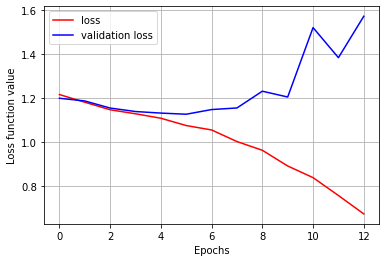

In [52]:
import matplotlib.pyplot as plt

plt.plot(model4.history.epoch, model4.history.history['loss'], 'r-', label='loss')
plt.plot(model4.history.epoch, model4.history.history['val_loss'], 'b-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function value')
plt.legend()
plt.grid()
plt.savefig(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy\loss_fun.png')

In [155]:
epochs = model4.history.epoch
acc = [100*x for x in model4.history.history['accuracy']]
val_acc = [100*x for x in model4.history.history['val_accuracy']]

plt.plot(epochs, acc, 'r-', label='accuracy')
plt.plot(epochs, val_acc, 'b-', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy value [%]')
plt.legend()
plt.grid()
plt.savefig(r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy\acc_val.png')

AttributeError: 'History' object has no attribute 'epoch'

In [23]:
model4.save(os.path.join(model_archive, model4_name))

INFO:tensorflow:Assets written to: C:\Users\MikołajStryja\Documents\Studia\master\trained_models\Sequential_4\assets


{}

In [60]:
# Model evaluation
val_nums = len(Xval)
import random
down = random.randint(0, val_nums//2)
# up = random.randint(down, val_nums)
evaluation_ids = Xval[down:down + 150]

In [64]:
eval_gen = DataGenerator(evaluation_ids, batch_size=16, shuffle=False)

In [73]:
results = model4.predict(eval_gen)

In [88]:
for elem in results:
    max_value = np.where(elem == np.amax(elem))
    elem[max_value] = 1
    elem[elem != 1] = 0

In [89]:
from master_lib.loader.data_loader import evaluate_categories
gt = []
for ids in evaluation_ids[:len(results)]:
    gt.append(evaluate_categories(os.path.basename(ids)))

gt = np.asarray(gt)

In [106]:
# Results displaying:
max_ = len(gt)
properly_defined_idxs = []
for i in range(max_):
    if np.array_equal(gt[i], results[i]):
        properly_defined_idxs.append(i)
        print(f"Predicted: {results[i]}, True label: {gt[i]}")
    # print(f"Predicted: {results[i]}, True label: {gt[i]}")

Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 1. 0.], True label: [0 0 1 0]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 1. 0.], True label: [0 0 1 0]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 1. 0. 0.], True label: [0 1 0 0]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 1. 0.], True label: [0 0 1 0]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 1. 0.], True label: [0 0 1 0]
Predicted: [0. 0. 0. 1.], True label: [0 0 0 1]
Predicted: [0. 0. 1. 0.], True label: [0 0 1 0]
Predicted: [0. 0. 1. 0.], True label: [0 0 1 0]
Predicted: [0. 0. 0. 1.], True label: [0

In [113]:
examples = []
for ID in properly_defined_idxs[:10]:
    examples.append(evaluation_ids[ID])

In [126]:
from master_lib.image_processing.processing import load_data_as_numpy_arr
%matplotlib inline

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
fig.tight_layout()

axs[0].imshow()

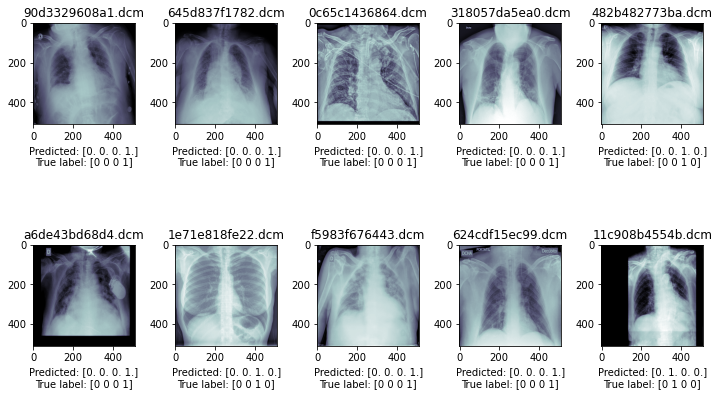

In [149]:
fig, axs = plt.subplots(2, 5, figsize=(12, 12))
plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=0.1, wspace=0.4)
j = 0
temp = 0
for i, exam in enumerate(examples):
    if i%5 == 0 and i != 0:
        j += 1
        temp = 0
    img = load_data_as_numpy_arr(exam)
    axs[j, temp].imshow(img, cmap=plt.cm.bone)
    axs[j, temp].set_xlabel(f"Predicted: {results[properly_defined_idxs[i]]}\nTrue label: {gt[properly_defined_idxs[i]]}")
    axs[j, temp].set_title(os.path.basename(exam))
    temp+=1

plt.show()


In [90]:
m = tf.keras.metrics.Precision()
r = tf.keras.metrics.Recall()

In [154]:
m.update_state(results, gt)
r.update_state(results, gt)
precision = m.result().numpy()
recall = r.result().numpy()
precision, recall, 2*precision*recall/(precision + recall)

(0.4027778, 0.4027778, 0.4027777910232544)

In [10]:
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 512, 512, 1)       0         
_________________________________________________________________
first_conv2d_filter (Conv2D) (None, 512, 512, 16)      416       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
second_conv2d_filter (Conv2D (None, 256, 256, 20)      2900      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 20)      0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 327680)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)               

In [11]:
loss, acc = new_model.evaluate(validation_generator, verbose=2)

113/113 - 445s - loss: 1.3293 - accuracy: 0.4989


In [15]:
results = new_model.predict(validation_generator)

In [18]:
results

array([[0.10837439, 0.15007892, 0.4985867 , 0.24295993],
       [0.03734677, 0.01813154, 0.0870087 , 0.857513  ],
       [0.06930477, 0.19256759, 0.13479416, 0.60333353],
       ...,
       [0.00850572, 0.04889364, 0.86332643, 0.07927419],
       [0.00156776, 0.09676883, 0.01530024, 0.88636315],
       [0.05344969, 0.18412675, 0.3503479 , 0.41207558]], dtype=float32)